# Dataset Features

This dataset provides information on a `(year, weekofyear)` timescale. Where applicable, units are indicated with a `_unit` suffix on the feature name.

## City and Date Indicators
- **city**: City abbreviations:
  - `sj` for San Juan
  - `iq` for Iquitos
- **week_start_date**: Date in `yyyy-mm-dd` format.

## NOAA's GHCN Daily Climate Data (Weather Station Measurements)
- **station_max_temp_c**: Maximum temperature (°C).
- **station_min_temp_c**: Minimum temperature (°C).
- **station_avg_temp_c**: Average temperature (°C).
- **station_precip_mm**: Total precipitation (mm).
- **station_diur_temp_rng_c**: Diurnal temperature range (°C).

## PERSIANN Satellite Precipitation Measurements
- **precipitation_amt_mm**: Total precipitation (mm) on a 0.25x0.25 degree scale.

## NOAA's NCEP Climate Forecast System Reanalysis Measurements
- **reanalysis_sat_precip_amt_mm**: Total precipitation (mm).
- **reanalysis_dew_point_temp_k**: Mean dew point temperature (K).
- **reanalysis_air_temp_k**: Mean air temperature (K).
- **reanalysis_relative_humidity_percent**: Mean relative humidity (%).
- **reanalysis_specific_humidity_g_per_kg**: Mean specific humidity (g/kg).
- **reanalysis_precip_amt_kg_per_m2**: Total precipitation (kg/m²).
- **reanalysis_max_air_temp_k**: Maximum air temperature (K).
- **reanalysis_min_air_temp_k**: Minimum air temperature (K).
- **reanalysis_avg_temp_k**: Average air temperature (K).
- **reanalysis_tdtr_k**: Diurnal temperature range (K).

## Satellite Vegetation - Normalized Difference Vegetation Index (NDVI)
(NOAA's CDR Normalized Difference Vegetation Index on a 0.5x0.5 degree scale)
- **ndvi_se**: NDVI for the pixel southeast of the city centroid.
- **ndvi_sw**: NDVI for the pixel southwest of the city centroid.
- **ndvi_ne**: NDVI for the pixel northeast of the city centroid.
- **ndvi_nw**: NDVI for the pixel northwest of the city centroid.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [2]:
train_features = pd.read_csv('dados/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv')

train_labels = pd.read_csv('dados/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv')

In [3]:
train_features.shape

(1456, 24)

In [4]:
train_labels.shape

(1456, 4)

In [5]:
train_features['city'].unique()

array(['sj', 'iq'], dtype=object)

# Análise exploratória dos dados

In [6]:
all_data = pd.merge(train_features, train_labels, on=['city', 'year', 'weekofyear'])

missing_values = all_data.isnull().sum()

missing_values[missing_values > 0]

ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64

In [7]:
# testando preencher os dados com a media
data_imputed = all_data.fillna(train_features.mean(numeric_only=True))

numerical_cols = data_imputed.select_dtypes(include=['float64', 'int64']).columns
numerical_data = data_imputed[numerical_cols]

In [48]:
categorical_cols = all_data.select_dtypes(include=['object']).columns



In [59]:
all_data.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Distribuição da variável 'city':
city
sj    936
iq    520
Name: count, dtype: int64


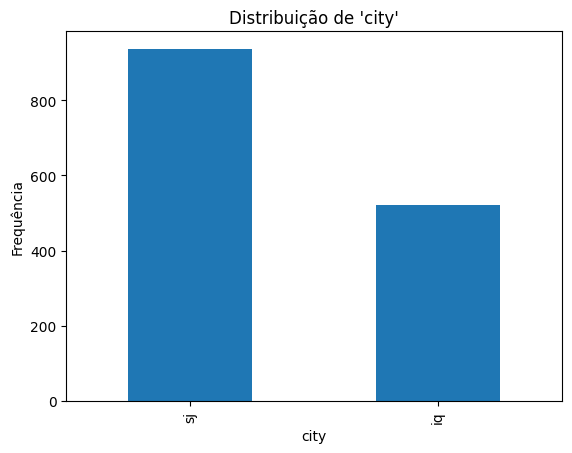

In [50]:
for col in categorical_cols[0:1]:
  print(f"Distribuição da variável '{col}':")
  print(all_data[col].value_counts())

  all_data[col].value_counts().plot.bar(title=f"Distribuição de '{col}'")
  plt.xlabel(col)
  plt.ylabel("Frequência")
  plt.show()

In [51]:
all_data.drop('week_start_date', axis=1, inplace=True)

In [52]:
pd.isnull(all_data).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_t

Podemos ver que praticamente todas as variáveis possuem dados faltando. Como podemos ver no gráfico abaixo.

Text(0.5, 0, 'Time')

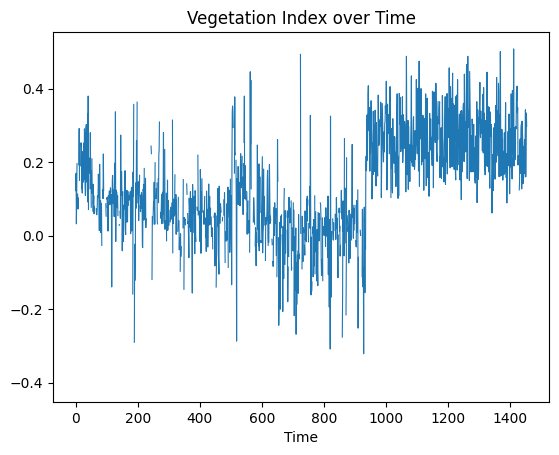

In [54]:
all_data.ndvi_ne.plot.line(lw=0.8)

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

Os dados faltando aparecem como "falhas" ou "gaps" no sinal.

## Fill NaN

Maneiras de solucionar isso são: Preencher os dados faltando com algum valor, pode ser média, ultimo valor válido. Ou ainda remover todos os dados. 

In [58]:
# Preenchendo os valores faltantes com a média dos valores anteriores
all_data.fillna(method='ffill', inplace=True)

/tmp/ipykernel_2669/1360302669.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)


Text(0, 0.5, 'Frequência')

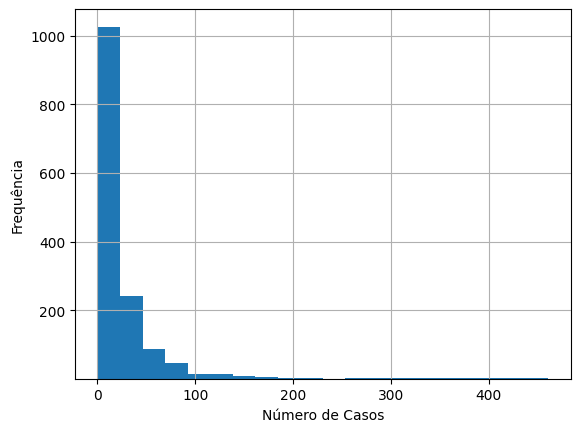

In [65]:
fig, ax = plt.subplots()
all_data['total_cases'].hist(bins=20, bottom=0.1)
ax.set_xlabel('Número de Casos')
ax.set_ylabel('Frequência')

In [8]:
# sns.pairplot(numerical_data)

<Axes: >

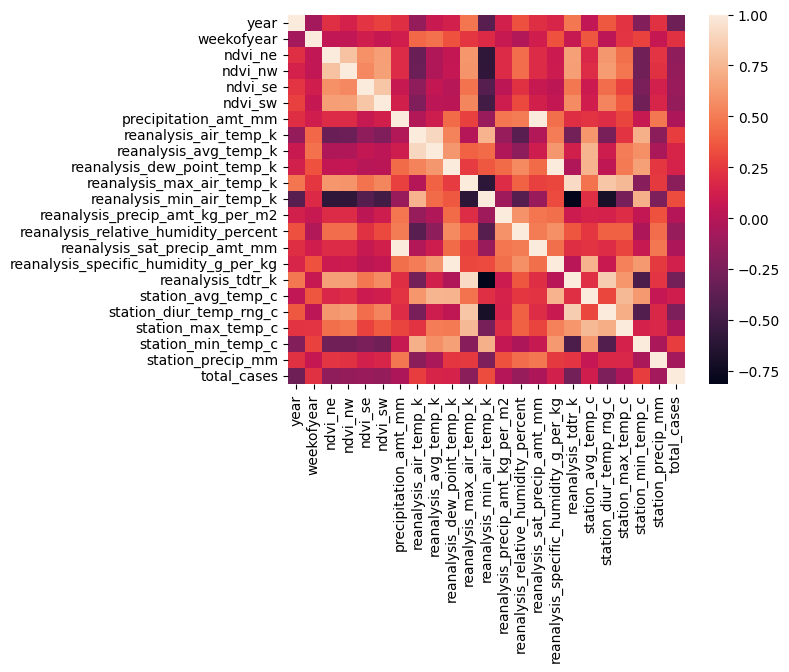

In [9]:
corr = numerical_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Correlação geral entre as features do dataset. Nota-se algumas correlações altas entre alguns parâmetros. Tais como: precipitação e umidade, vegetação e temperatura mais baixa, entre outros.

In [67]:
sj_correlations = all_data[all_data['city'] == 'sj'][all_data.columns[3:]].corr()
iq_correlations = all_data[all_data['city'] == 'iq'][all_data.columns[3:]].corr()


Text(0.5, 1.0, 'San Juan Variable Correlations')

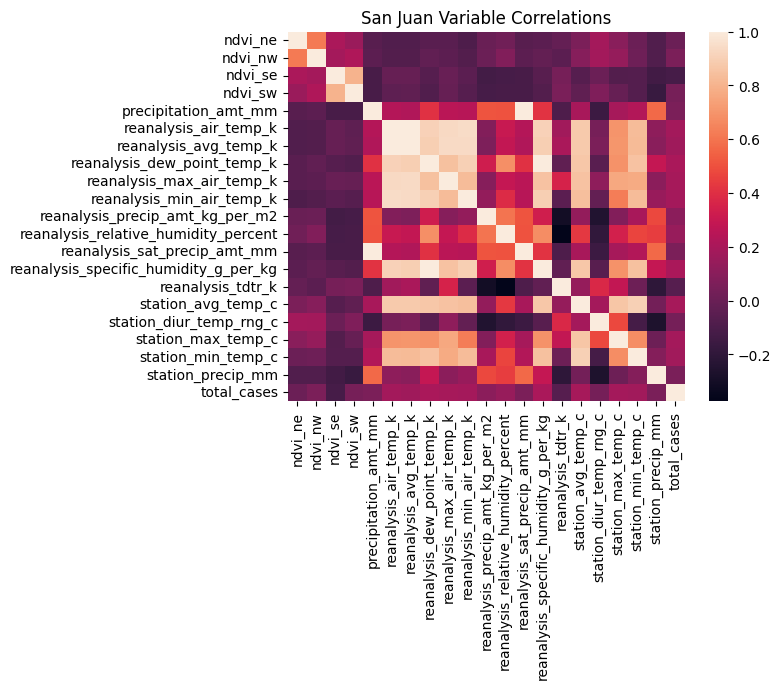

In [68]:
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

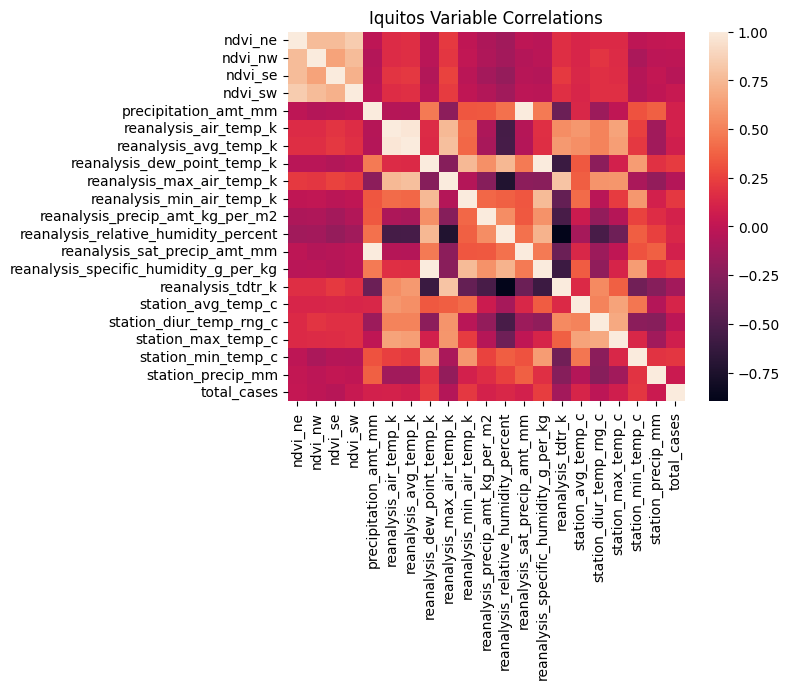

In [69]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

Nota-se que algumas correlações se manté, se comparado com o dataset geral, mas entre as duas cidades, as correlações entre as variáveis muda bastante. Um dos fatores que pode influenciar é a vegetação predominante do local.

# Análise de segmentação

In [10]:
numerical_data.head()
# numerical_data.drop(['year', 'weekofyear'], axis=1, inplace=True)

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


### Testando métodos de clusterização

In [11]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(numerical_data)

# # Convertendo para DataFrame para manter a estrutura
# scaled_data_df = pd.DataFrame(scaled_data, columns=numerical_cols)

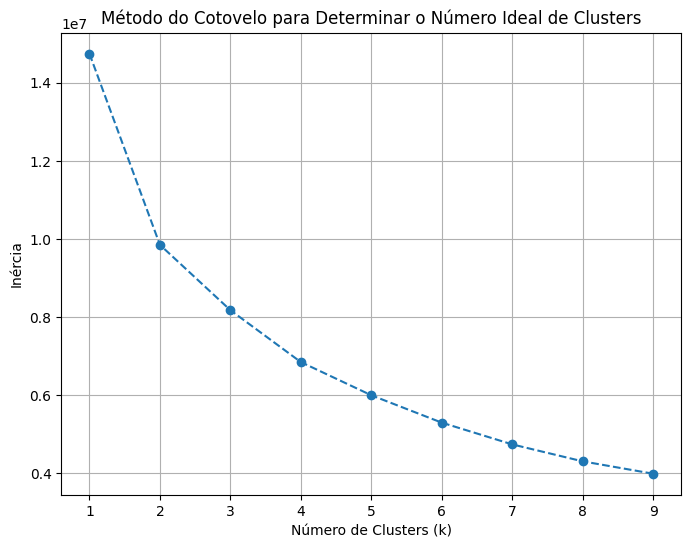

In [12]:
inertia_reduced = []
k_values_reduced = range(1, 10)  # Testando de 1 a 6 clusters

for k in k_values_reduced:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numerical_data)
    inertia_reduced.append(kmeans.inertia_)

# Plotando o método do cotovelo com clusters reduzidos
plt.figure(figsize=(8, 6))
plt.plot(k_values_reduced, inertia_reduced, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
plt.grid()
plt.show()

### Kmeans

In [30]:
# Aplicando K-Means para as variáveis selecionadas (temperatura)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit(numerical_data)

In [31]:
kmeans.predict(numerical_data)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [32]:
labels_clusters = kmeans.labels_

In [33]:
labels_series = pd.Series(labels_clusters, name = "label")

In [34]:
df_result = pd.concat([numerical_data, labels_series], axis = 1)

<Axes: xlabel='station_avg_temp_c', ylabel='station_precip_mm'>

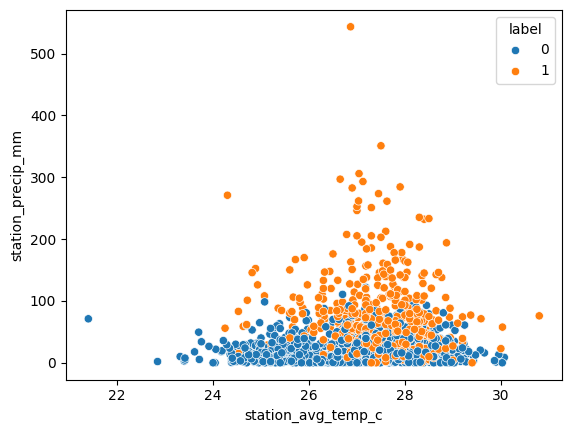

In [35]:
sns.scatterplot(data = df_result,
                x = "station_avg_temp_c",
                y = "station_precip_mm",
                hue = "label")

## Teste DBSCAN

In [36]:
dbscan = DBSCAN()
dbscan.fit(numerical_data) 

DBSCAN()

In [37]:
def plot_dbscan(df, eps, min_pts, x1, x2):
     # Instanciamento e fit do modelo
    dbscan = DBSCAN(eps = eps, min_samples = min_pts)
    dbscan.fit(df)

    # ========================================
    # estruturação dos resultados
    labels_clusters = dbscan.labels_
    labels_series = pd.Series(labels_clusters, name="label")

    df_result = pd.concat([df, labels_series], axis=1)
    n_clusters = pd.Series(labels_clusters).nunique()

    # ========================================
    print(f"DBSCAN com eps={eps} e minPts={min_pts}\nNúmero de clusters: {n_clusters}")
    sns.scatterplot(data=df_result, x=x1, y=x2, hue="label", palette="tab10")
    plt.show()

    print("Quantidade de pontos em cada clusters:")
    print(pd.Series(labels_clusters).value_counts())

    return df_result, n_clusters

DBSCAN com eps=20 e minPts=6
Número de clusters: 7


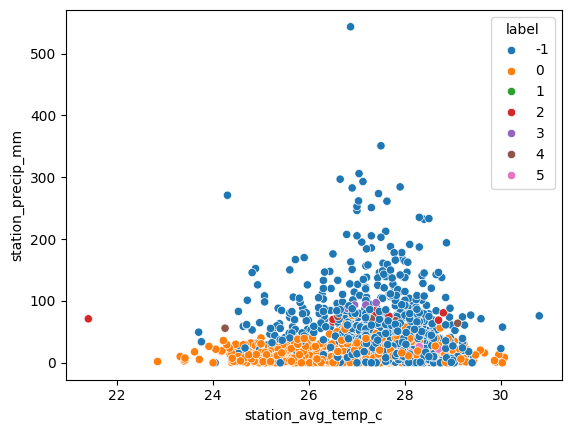

Quantidade de pontos em cada clusters:
-1    724
 0    699
 2     10
 1      6
 4      6
 3      6
 5      5
Name: count, dtype: int64


In [74]:
df_result, n_clusters = plot_dbscan(numerical_data,
                                   eps = 20,
                                   x1 = "station_avg_temp_c",
                                   x2 = "station_precip_mm",
                                   min_pts = 6)

In [40]:
dimensionalidade = numerical_data.shape[1]  # Número de colunas (dimensões)
MinPts = 2 * dimensionalidade
print(f"MinPts definido como: {MinPts}")

MinPts definido como: 46


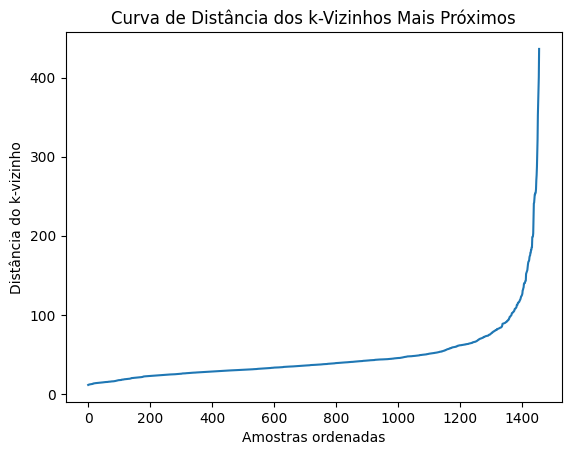

In [41]:
nbrs = NearestNeighbors(n_neighbors=MinPts).fit(numerical_data)
distances, _ = nbrs.kneighbors(numerical_data)

# Ordenando as distâncias para encontrar o ponto de cotovelo
distances = np.sort(distances[:, MinPts - 1])  # Distância do k-vizinho mais distante
plt.plot(distances)
plt.title("Curva de Distância dos k-Vizinhos Mais Próximos")
plt.xlabel("Amostras ordenadas")
plt.ylabel("Distância do k-vizinho")
plt.show()

In [42]:
# Testar diferentes combinações
eps_values = np.linspace(0.1, 50, 100)  # Intervalo de Eps
minpts_values = [2, 4, 6, 8]  # Diferentes valores para MinPts

melhor_silhouette = -1
melhor_configuracao = None

for eps in eps_values:
    for minpts in minpts_values:
        dbscan = DBSCAN(eps=eps, min_samples=minpts).fit(numerical_data)
        labels = dbscan.labels_

        # Ignorar clusters com ruído total
        if len(set(labels)) > 1:
            score = silhouette_score(numerical_data, labels)
            print(f"Eps: {eps}, MinPts: {minpts}, Silhouette Score: {score:.3f}")

            if score > melhor_silhouette:
                melhor_silhouette = score
                melhor_configuracao = (eps, minpts)

print(f"Melhor configuração: Eps = {melhor_configuracao[0]}, MinPts = {melhor_configuracao[1]}")

Eps: 1.1080808080808082, MinPts: 2, Silhouette Score: -0.287
Eps: 1.6121212121212123, MinPts: 2, Silhouette Score: -0.287
Eps: 2.1161616161616164, MinPts: 2, Silhouette Score: -0.287
Eps: 2.6202020202020204, MinPts: 2, Silhouette Score: -0.287
Eps: 3.1242424242424245, MinPts: 2, Silhouette Score: -0.287
Eps: 3.6282828282828286, MinPts: 2, Silhouette Score: -0.438
Eps: 4.132323232323232, MinPts: 2, Silhouette Score: -0.449
Eps: 4.636363636363637, MinPts: 2, Silhouette Score: -0.455
Eps: 5.14040404040404, MinPts: 2, Silhouette Score: -0.448
Eps: 5.14040404040404, MinPts: 4, Silhouette Score: -0.164
Eps: 5.644444444444444, MinPts: 2, Silhouette Score: -0.441
Eps: 5.644444444444444, MinPts: 4, Silhouette Score: -0.174
Eps: 6.148484848484848, MinPts: 2, Silhouette Score: -0.461
Eps: 6.148484848484848, MinPts: 4, Silhouette Score: -0.169
Eps: 6.148484848484848, MinPts: 6, Silhouette Score: -0.161
Eps: 6.148484848484848, MinPts: 8, Silhouette Score: -0.162
Eps: 6.652525252525253, MinPts: 2, S

## Teste separando o dataset em risco alto e baixo.

- Número de casos acima da mediana ou percentil 75 pode ser considerado como alto risco, enquanto valores abaixo disso são baixo risco.
- 1 para alto risco e 0 para baixo risco

In [26]:
risk_threshold = train_labels['total_cases'].quantile(0.75)

# Criando a nova variável de risco
train_labels['risk_level'] = (train_labels['total_cases'] > risk_threshold).astype(int)

# Exibindo a distribuição das classes (0: baixo risco, 1: alto risco)
class_distribution = train_labels['risk_level'].value_counts()

In [27]:
class_distribution

risk_level
0    1102
1     354
Name: count, dtype: int64

In [82]:
all_data.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

<Axes: xlabel='ndvi_nw', ylabel='station_avg_temp_c'>

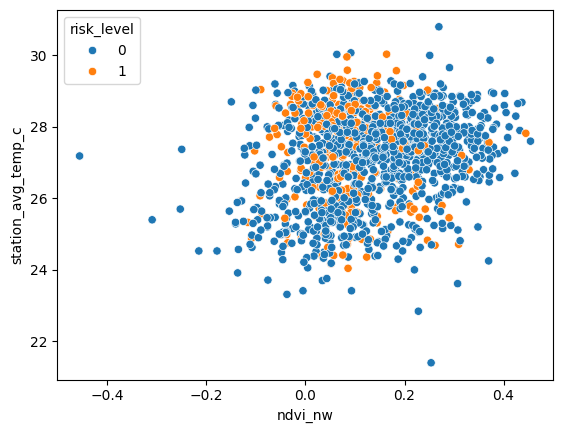

In [86]:
sns.scatterplot(data = data,
                x = "ndvi_nw",
                y = "station_avg_temp_c",
                hue = "risk_level")

<Axes: xlabel='station_avg_temp_c', ylabel='station_precip_mm'>

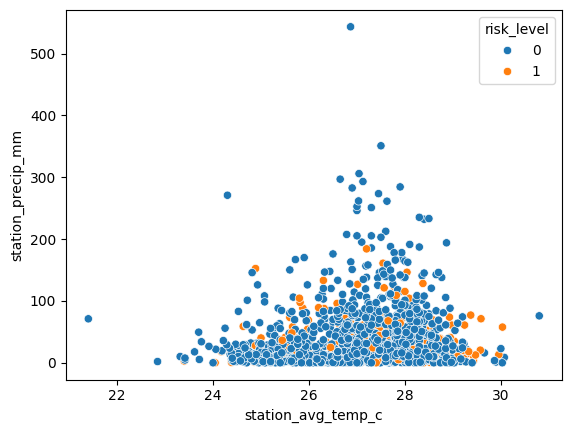

In [85]:
data = pd.merge(train_features, train_labels[['city', 'year', 'weekofyear', 'risk_level']], on=['city', 'year', 'weekofyear'])
sns.scatterplot(data = data,
                x = "station_avg_temp_c",
                y = "station_precip_mm",
                hue = "risk_level")

Percebe-se que nao conseguimos separa as condições de temperatura, precipitação... de acordo com a incidência de casos de dengue. Logo a clusterização nesses parâmetros se torna mais complicada para esse dataset. 

Predisposição para casos de dengue é a partir de ~ 25 graus

<Axes: xlabel='ndvi_nw', ylabel='station_avg_temp_c'>

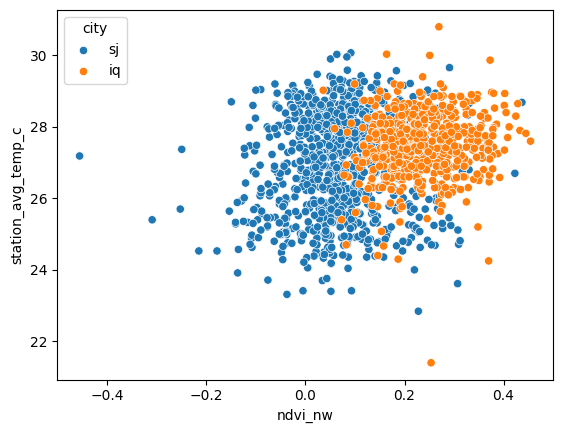

In [87]:
sns.scatterplot(data = all_data,
                x = "ndvi_nw",
                y = "station_avg_temp_c",
                hue = "city")

<Axes: xlabel='station_avg_temp_c', ylabel='station_precip_mm'>

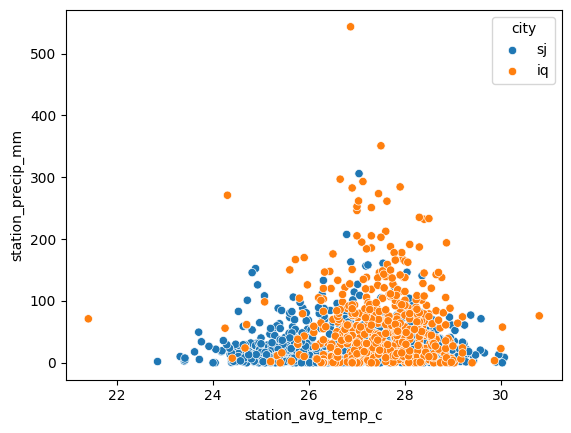

In [83]:
sns.scatterplot(data = all_data,
                x = "station_avg_temp_c",
                y = "station_precip_mm",
                hue = "city")

In [81]:
casos_sj = all_data[all_data['city'] == 'sj']['total_cases'].mean()
casos_iq = all_data[all_data['city'] == 'iq']['total_cases'].mean()

print(f"Media de casos em San Juan: {casos_sj}")
print(f"Media de casos em Iquitos: {casos_iq}")

Media de casos em San Juan: 34.18055555555556
Media de casos em Iquitos: 7.565384615384615


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

data = pd.merge(train_features, train_labels[['city', 'year', 'weekofyear', 'risk_level']], on=['city', 'year', 'weekofyear'])

# Selecionando apenas variáveis numéricas e o rótulo
X = data.select_dtypes(include=['float64', 'int64']).drop(columns=['risk_level'])
y = data['risk_level']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reaplicando o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Fazendo previsões
y_pred = rf_model.predict(X_test)

# Avaliando o modelo
classification_rep = classification_report(y_test, y_pred, target_names=["Baixo Risco", "Alto Risco"])
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibindo diretamente os resultados para evitar erros


('              precision    recall  f1-score   support\n\n Baixo Risco       0.85      0.97      0.90       221\n  Alto Risco       0.82      0.46      0.59        71\n\n    accuracy                           0.85       292\n   macro avg       0.84      0.72      0.75       292\nweighted avg       0.84      0.85      0.83       292\n',
 array([[214,   7],
        [ 38,  33]]))

In [47]:
print(classification_rep)

              precision    recall  f1-score   support

 Baixo Risco       0.85      0.97      0.90       221
  Alto Risco       0.82      0.46      0.59        71

    accuracy                           0.85       292
   macro avg       0.84      0.72      0.75       292
weighted avg       0.84      0.85      0.83       292



<Axes: >

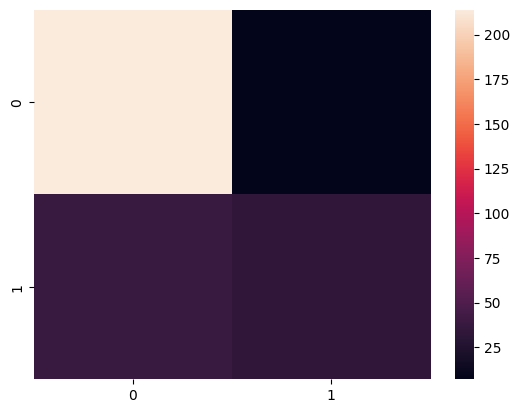

In [29]:
sns.heatmap(conf_matrix)